In [1]:
import numpy as np
import pandas as pd
import os
cnt=0
for dirname, _, filenames in os.walk('../Stocks/'):
    for filename in filenames:
#         print(os.path.join(dirname, filename))
        cnt+=1
print(cnt, 'files in','../Stocks/', 'folder')
date_start = '2010-01-01'
date_end = '2014-12-30'
# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

7195 files in ../Stocks/ folder


In [2]:
df = pd.read_csv('../Stocks/ach.us.txt', delimiter=',')
df.head(8)

,Date,Open,High,Low,Close,Volume,OpenInt
0,2005-02-25,15.767,16.286,15.767,16.246,886907,0
1,2005-02-28,16.616,16.616,16.356,16.556,775943,0
2,2005-03-01,16.576,16.576,16.166,16.186,536390,0
3,2005-03-02,15.667,15.667,15.477,15.537,507548,0
4,2005-03-03,15.637,15.657,15.517,15.587,206304,0
5,2005-03-04,15.218,15.567,15.218,15.477,470293,0
6,2005-03-07,15.837,16.056,15.787,15.937,215117,0
7,2005-03-08,16.156,16.186,15.966,16.016,274805,0


In [3]:
d_files = dict()
def get_names(date_start = '2010-01-01', date_end = '2014-12-30'):
    import os 
    from pandas.errors import EmptyDataError 
    global d_files
    names = []
    for dirname, _, filenames in os.walk('../Stocks/'):
        for filename in filenames:
            filepath = os.path.join(dirname, filename)
            try:
                df = pd.read_csv(filepath, delimiter=',')
                df = df[(df['Date']>date_start) & (df['Date']<=date_end)]
                if df.shape[0] == 1256:
                    names.append(filepath)
                if df.shape[0] in d_files.keys():
                    d_files[df.shape[0]] += 1
                else:
                    d_files[df.shape[0]] = 1
                # TODO
                #if df.shape[0] == 1257 (324 companies):
                #.   define method merge_dates()
                #    names.append(filepath)
            except EmptyDataError:
                continue
    return names

In [4]:
import time
start_time = time.time()
valid_names = get_names()
print("--- %s seconds ---" % (time.time() - start_time))
print(format(len(valid_names)/cnt, '%'), f'({len(valid_names)})', 'files are valid')

--- 55.71943807601929 seconds ---
33.856845% (2436) files are valid


In [5]:
print(dict(sorted(d_files.items(), key=lambda item: item[1], reverse = True)[:10]))

{1256: 2436, 0: 1967, 1257: 367, 1255: 74, 1096: 62, 1254: 41, 1253: 22, 1251: 21, 1252: 20, 1248: 16}


In [15]:
start_time = time.time()

tickers = []
Open = []
Close = []
High = []
Low = []
Volume = []
for filename in valid_names:
    ticker = filename.split('/')[-1].strip('.txt')
    tickers.append(ticker)
    
    df = pd.read_csv(filename, delimiter=',')
    df = df[(df['Date']>date_start) & (df['Date']<=date_end)]
    Open.append(np.array(df['Open']))
    Close.append(np.array(df['Close']))
    High.append(np.array(df['High']))
    Low.append(np.array(df['Low']))
    Volume.append(np.array(df['Volume']))

# filtering
tickers = np.array(tickers) #[aa]
    
dates = np.array(df['Date'])
Open = pd.DataFrame(Open, columns = dates, index = tickers)
Close = pd.DataFrame(Close, columns = dates, index = tickers)
High = pd.DataFrame(High, columns = dates, index = tickers)
Low = pd.DataFrame(Low, columns = dates, index = tickers)
Volume = pd.DataFrame(Volume, columns = dates, index = tickers)
print("--- %s seconds ---" % (time.time() - start_time))

--- 20.049997568130493 seconds ---


In [ ]:
aa

In [2566]:
Open = Open.iloc[aa]
Close = Close.iloc[aa]
High = High.iloc[aa]
Low = Low.iloc[aa]
Volume = Volume.iloc[aa]

In [7]:
N = len(Close)
N

2436

In [8]:
def q_to_alpha(q):
    x = q - np.array(q).mean()
    return (x)/np.linalg.norm(x, ord=1)

In [9]:
def apply_decay(A, a, n=4):
    x = a
    for i in range(min(n, len(A))):
        x += A[-i-1]*(n-i-1)/n
    x /= np.linalg.norm(x, ord=1)
    assert len(x) == N
#     result = x / np.linalg.norm(x, ord=1)
    return x

In [10]:
def truncate_a(a, max_weight=0.03):
    def iteration(a):
        signs = np.sign(a)
        _a = np.min(np.vstack([np.abs(a), np.ones(N) * max_weight]), axis=0)
        _a *= signs
#         _a -= _a.mean()
#         _a /= np.linalg.norm(_a, ord=1)
        return _a
    
    
#     _a = iteration(_a)
    signs = np.sign(a)
    _a = np.vstack([np.abs(a), np.ones(N)*max_weight]).min(0)*signs
    
    return _a

In [11]:
def ranked_alpha(q, n=10):
    a = np.zeros(N)
    a[np.array(q).argsort()[:n]] -= 1
    a[np.array(-q).argsort()[:n]] += 1
    return a / (2*n)

In [12]:
def sigma_RS(T, i):
    start_index = max(i-T, 0)
    end_index = i
    
    log_h_c = np.log(High.T.iloc[start_index:end_index] / Close.T.iloc[start_index:end_index])
    log_h_o = np.log(High.T.iloc[start_index:end_index] / Open.T.iloc[start_index:end_index])
    log_l_c = np.log(Low.T.iloc[start_index:end_index] / Close.T.iloc[start_index:end_index])
    log_l_o = np.log(Low.T.iloc[start_index:end_index] / Open.T.iloc[start_index:end_index])
    
    return (log_h_c * log_h_o + log_l_c * log_l_o).sum() / T

In [13]:
def sigma_XZ(T, i):
    start_index = max(i-T, 0)
    end_index = i
    end_index_prev = max(i, 0)
    alpha = 1.34
    k = (alpha-1)/(alpha + (T+1)/(T-1))
    
    log_o_c = np.log(Open.T.iloc[start_index:end_index] / Close.T.iloc[start_index:end_index_prev])
    log_o_c_curr = np.log(Open.T.iloc[start_index:end_index] / Close.T.iloc[start_index:end_index])
    
    sigma_0 = ((log_o_c - log_o_c.mean())**2).sum() / (T-1)
    sigma_c = ((log_o_c_curr - log_o_c_curr.mean())**2).sum() / (T-1)
    sigma_rs = sigma_RS(T, i)
    
    return sigma_0 + k * sigma_c + (1-k)*sigma_rs

In [16]:
from tqdm.notebook import tqdm

A = []

A_reversions = []
A_volatilities = []

pnls = []
pnls_reversions = []
pnls_volatilities = []

turnovers = []
sharpe_ratios = []
comission_ratio = 0.00004
n = 5
pm_n = 252
T_volatility = 5
T = 252
alpha_initial = q_to_alpha(np.random.randn(N))
q_volatilities = []

def f(q):
    return 1 / (1 + np.exp(-q))

for i, close in tqdm(enumerate(Close)):
    if i<n:
        A.append(alpha_initial)
        q_volatilities.append(0)
    elif i>=n:
        q_reversion = (Close.T.iloc[i-n].values - Close.T.iloc[i-1].values) / Close.T.iloc[i-n].values
        q_reversion = ranked_alpha(q_reversion)
        q_volatilities.append(sigma_XZ(T_volatility, i))
        
        
#         q_reversion *= (Volume.T.iloc[i-1].values) / Volume.T.iloc[i-1].values.sum()
        
        q_volatility = q_volatilities[i]
        q_volatility = ranked_alpha(q_volatility)
        
        # putting alphas
        A_reversions.append(ranked_alpha(q_reversion))
        A_volatilities.append(ranked_alpha(q_volatility))
        
        reversions_returns = A_reversions[-1] * (Close.T.iloc[i-2] - Close.T.iloc[i-1]) / Close.T.iloc[i-2]
        volatility_returns = A_volatilities[-1] * (Close.T.iloc[i-2] - Close.T.iloc[i-1]) / Close.T.iloc[i-2]
        
        A_cov = np.cov(np.stack((reversions_returns, volatility_returns), axis=0))


        A_inv = np.linalg.inv(A_cov)
        a_returns = np.array([reversions_returns.mean(), volatility_returns.mean()])
        c = A_inv@a_returns / (a_returns.T @ A_inv @ a_returns)

        q = 0
        q += q_reversion * c[0] / np.linalg.norm(c, ord=1)
        q += q_volatility * c[1] / np.linalg.norm(c, ord=1)
        assert len(q) == N
#         q = f(q)

        x = q
        a = A[-1]
        a += x * (0.3 * min(1, i/252))
#         a = apply_decay(A, a)
        a = truncate_a(a, 0.03)
        a = q_to_alpha(a)
        
        
        a = q_to_alpha(a)
        
#         a = q_to_alpha(q)
#         a = A[-1] + a
#         a /= np.linalg.norm(a, ord=1)
        assert np.linalg.norm(a, ord=1) - 1 < 0.001
        assert np.abs(np.array(a).sum()) < 0.001
        A.append(a)
    
    r = (Close.T.iloc[i].values - Close.T.iloc[i-1].values) / Close.T.iloc[i-1].values
    
    turnover = np.abs(A[-1] - A[-2]).sum() * 100 if i >= n else 0
    turnovers.append(turnover)
    
    pnl = ((A[-2] * r).sum()) if i >= n else 0
    pnls.append(pnl)
    
    sharpe_ratio = np.array(pnls[-T:]).mean() / np.array(pnls[-T:]).std() * (252**0.5)
    sharpe_ratios.append(sharpe_ratio)

0it [00:00, ?it/s]

D:\programs\Anaconda\lib\site-packages\ipykernel_launcher.py:85: RuntimeWarning: invalid value encountered in double_scalars


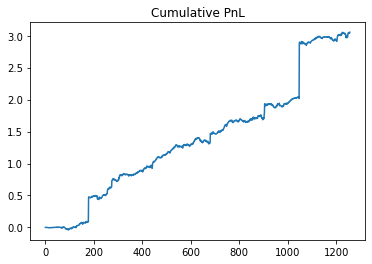

In [17]:
from matplotlib import pyplot as plt

plt.plot(np.cumsum(pnls))
plt.title('Cumulative PnL')
plt.show()

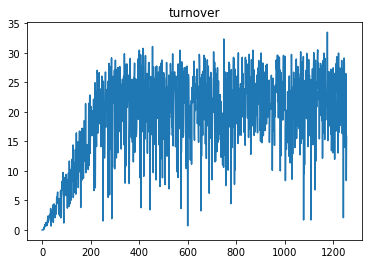

19.196167399845844


In [18]:
plt.plot(turnovers)
plt.title('turnover')
plt.show()
print(np.array(turnovers).mean())

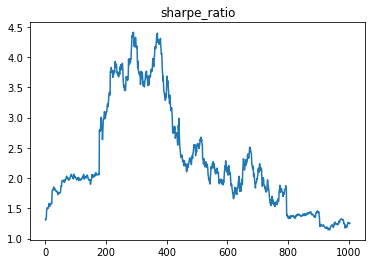

In [19]:
plt.plot(sharpe_ratios[252:])
plt.title('sharpe_ratio')
plt.show()

In [20]:
sharpes = []
sharpe_length = 252

returns = np.cumsum(pnls)
return_prev = 0

for i in range(0, len(pnls), sharpe_length):
    sharpe_pnls = pnls[i:i+sharpe_length]
    mu = np.array(sharpe_pnls).mean()
    std = np.array(sharpe_pnls).std()
    
    current_return = returns[min(i+sharpe_length, len(pnls) - 1)]
    sharpes.append(((current_return - return_prev), mu / std * sharpe_length**0.5, np.array(turnovers[i:i+sharpe_length]).sum() / sharpe_length))
    return_prev = current_return
    
print('\n'.join(map(str, sharpes)))

(0.5236466826302193, 1.2909981853553214, 9.877450854469334)
(0.6496335093546748, 3.873845307306297, 21.30959022842455)
(0.486952378048636, 2.5291171557649155, 20.894546260540693)
(0.31554000237759405, 1.560597853937388, 22.01929501821138)
(1.0777887838687217, 1.2473974842597917, 21.575253567744433)


In [2581]:
np.array(sharpes).min(0)

array([0.12284634, 2.04309083, 5.69492524])